In [1]:
from models import Model1, Model2, Model2Tanh, Model3
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data 
import torch.nn.functional as F
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#Transformations
train_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                ])

test_transforms = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

#Creating the Datasets
trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)
testset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=test_transforms)


#Data Loaders
batch_size = 2500
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batch_size,
                                        shuffle=True, pin_memory=True)

valloader = torch.utils.data.DataLoader(testset, batch_size = batch_size, shuffle = True, pin_memory = True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                        shuffle=False, pin_memory=True)


classes = ('plane', 'car', 'bird', 'cat',
'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def trainNetwork(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    model = model()
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.001, betas= (0.9, 0.999), eps = 1e-08, weight_decay=0)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results 
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)


def trainNetworkAdamax(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    model = model()
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.Adamax(model.parameters(), lr = 0.001, betas= (0.9, 0.999), eps = 1e-08, weight_decay=0)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results 
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)

def trainNetworkSGD(model, lossfunc, trainloader, valloader = None, scorefuncs = None, epochs = 100, device = "cuda:0", checkpoint_file = None):
    
    #Model -> the model to train
    # Loss function -> the lost function that takes in two arguemnts, the model outputs and the labels and returns a score
    # Train loader -> the PyTorch DataLoader object
    # valloader -> an optional DataLoader for validation after every epoch
    # scorefuncs -> dictionary of scoring functions to evaluate the performance
    # epochs -> number of epochs to perform
    #device -> the location of which to perform computation
    
    model = model()
    tracking = ["epoch", "total time", "train loss", "total correct"]
    if valloader is not None:
        tracking.append("val loss")
        
    for evalscore in scorefuncs.keys():
        tracking.append("train " + evalscore)
        if valloader is not None:
            tracking.append("val " + evalscore)
            
    totaltraintime = 0 # The time spent in the training loop
    results = {}
    
    #initialising every item with an empty list
    for item in tracking:
        results[item] = []
    
    optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
    
    model.to(device)
    
    for epoch in range(epochs):
        model = model.train()
        total_correct = 0
        total_loss = 0.0
        
        y_true = []
        y_pred = []
        start = time.time()
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            output = model(inputs).to(device)
            loss = lossfunc(output, labels)
            
            loss.backward()
            
            optimizer.step()
            total_loss += loss.item()
            total_correct += output.argmax(dim=1).eq(labels).sum().item()
            
            labels = labels.detach().cpu().numpy()
            output = output.detach().cpu().numpy()
            
            for i in range(inputs.shape[0]):
                y_true.append(labels[i])
                y_pred.append(output[i,:])
        end = time.time()
        totaltraintime += (end-start)
        
        results["epoch"].append(epoch)
        results["total time"].append(totaltraintime)
        results["train loss"].append(total_loss)
        results["total correct"].append(total_correct)
        
        y_pred = np.asarray(y_pred)
        
        if y_pred.shape[1] >1:
            y_pred = np.argmax(y_pred, axis = 1)
            
        for name, scorefunc in scorefuncs.items():
            results["train " + name].append( scorefunc(y_true, y_pred) )
            
        if valloader is None:
            pass
        else:
            #validation performance
            model = model.eval() #setting to evaluation  mode
            y_true = []
            y_pred = []
            
            total_loss = 0.0
            total_correct = 0
            
            for inputs, labels in valloader:
                inputs, labels = inputs.cuda(), labels.cuda()
                
                output = model(inputs).to(device)
                
                loss = lossfunc(output, labels)
                
                total_loss += loss.item()
                total_correct += output.argmax(dim=1).eq(labels).sum().item()
                
                labels = labels.detach().cpu().numpy()
                output = output.detach().cpu().numpy()
                for i in range(batch_size):
                    y_true.append(labels[i])
                    y_pred.append(output[i,:])
                
            results["val loss"].append(total_loss)
            y_pred = np.asarray(y_pred)
            
            if y_pred.shape[1] >1:
                y_pred = np.argmax(y_pred, axis =1)
                
            for name, scorefunc in scorefuncs.items():
                results["val " + name].append( scorefunc(y_true, y_pred) )
        if checkpoint_file is not None:
            torch.save({
                'epoch' : epoch,
                'model_state_dict' : model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results 
            }, checkpoint_file)    
    
    return pd.DataFrame.from_dict(results)

In [5]:
lossfunc = nn.CrossEntropyLoss()
model = Model1
model1Results = trainNetwork(model, lossfunc =lossfunc, trainloader =trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)

KeyboardInterrupt: 

<Axes: xlabel='epoch', ylabel='train accuracy'>

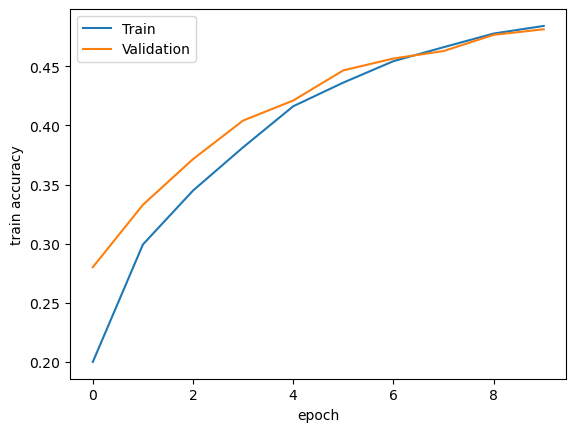

In [46]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

In [45]:
lossfunc = nn.CrossEntropyLoss()
modelAdamax = Model1
model1ResultAdamax = trainNetworkAdamax(modelAdamax, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)

<Axes: xlabel='epoch', ylabel='train accuracy'>

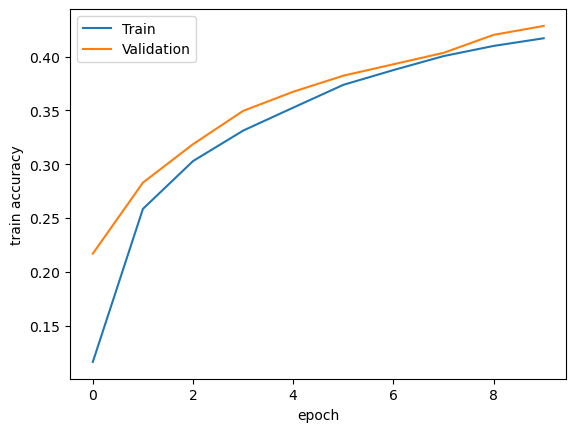

In [47]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultAdamax, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultAdamax, label = 'Validation')

In [42]:
lossfunc = nn.CrossEntropyLoss()
modelSGD= Model1
model1ResultSGD = trainNetworkSGD(modelSGD, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=10)

<Axes: xlabel='epoch', ylabel='train accuracy'>

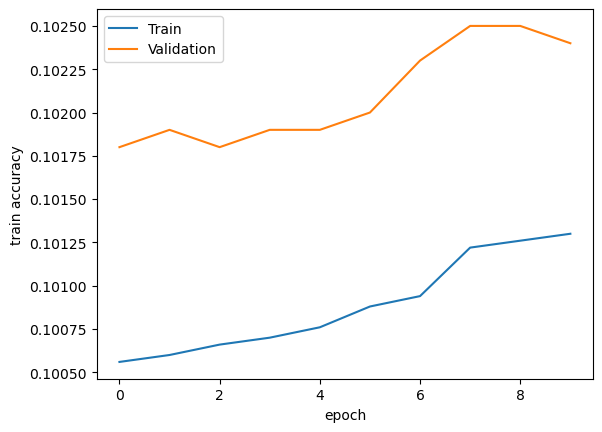

In [43]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation')

<Axes: xlabel='epoch', ylabel='train accuracy'>

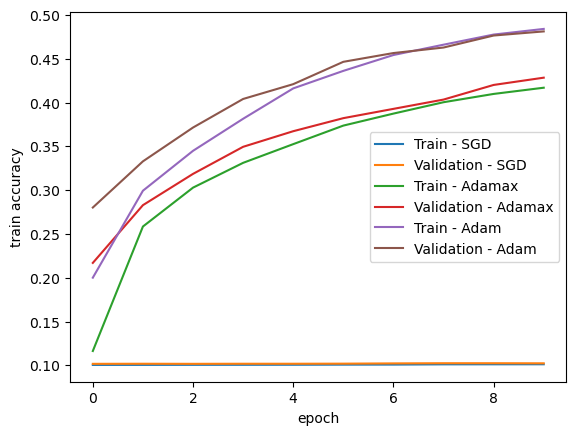

In [49]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train - SGD')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation - SGD')
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultAdamax, label = 'Train - Adamax')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultAdamax, label = 'Validation - Adamax')
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation - Adam')

In [36]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Model1()
model.to(device)
with torch.no_grad():
    correct = 0
    for x_test, y_test in testloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_val = model(x_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len( testset)} = {correct.item()*100/(len(testset)):7.3f}%')

Test accuracy: 1001/10000 =  10.010%


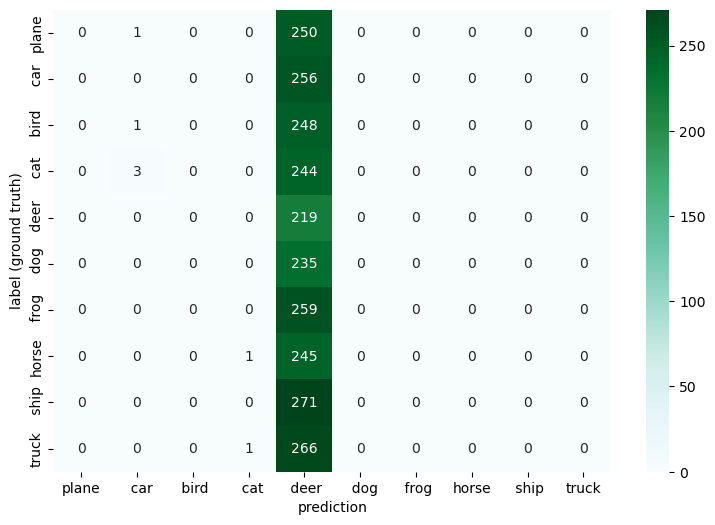

In [21]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [53]:
lossfunc = nn.CrossEntropyLoss()
model = Model1
model1Results = trainNetwork(model, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)
print(model1Results)

    epoch  total time  train loss  total correct  val loss  train accuracy  \
0       0   10.786492   43.941133           8919  8.082217         0.17838   
1       1   21.157492   38.613163          15492  7.439938         0.30984   
2       2   31.524991   36.422923          17284  7.068788         0.34568   
3       3   41.866992   34.520111          18699  6.715953         0.37398   
4       4   52.127492   33.018775          19888  6.478140         0.39776   
5       5   62.708992   31.974551          20829  6.270747         0.41658   
6       6   72.898492   31.119189          21826  6.131892         0.43652   
7       7   83.091492   30.466264          22339  6.051849         0.44678   
8       8   93.575993   29.932909          22851  5.971068         0.45702   
9       9  103.828492   29.499455          23207  5.874433         0.46414   
10     10  114.331993   29.000623          23795  5.778561         0.47590   
11     11  124.515493   28.590294          24113  5.728134      

<Axes: xlabel='epoch', ylabel='train accuracy'>

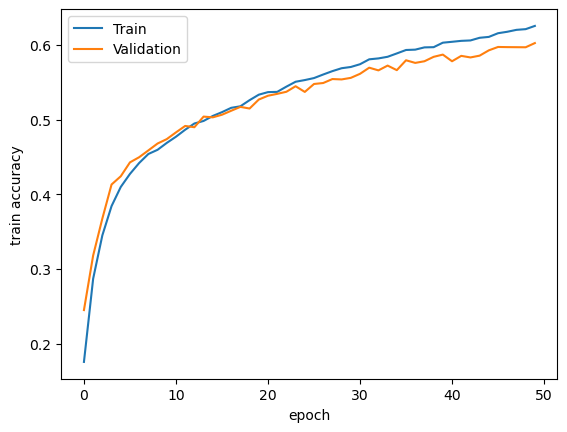

In [24]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation')

In [26]:
lossfunc = nn.CrossEntropyLoss()
modelAdamax = Model1
model1ResultsAdaMax = trainNetworkAdamax(modelAdamax, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

<Axes: xlabel='epoch', ylabel='train accuracy'>

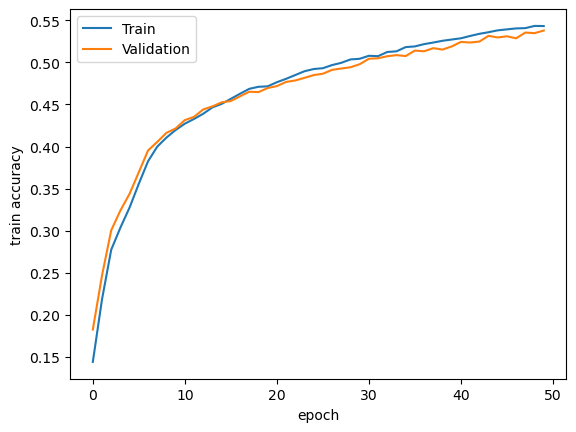

In [27]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultsAdaMax, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultsAdaMax, label = 'Validation')

In [50]:
lossfunc = nn.CrossEntropyLoss()
modelSGD= Model1
model1ResultSGD = trainNetworkSGD(modelSGD, lossfunc, trainloader, valloader=valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

<Axes: xlabel='epoch', ylabel='train accuracy'>

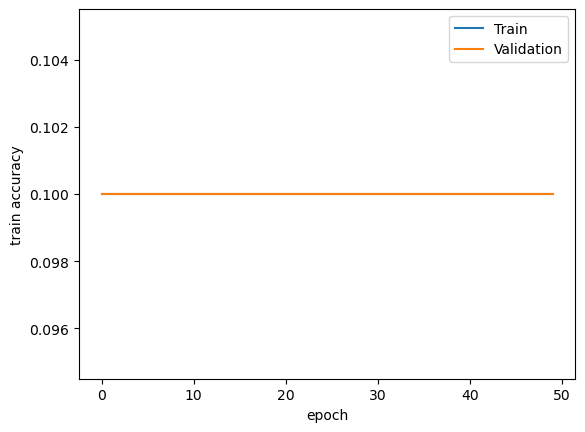

In [51]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation')

<Axes: xlabel='epoch', ylabel='train accuracy'>

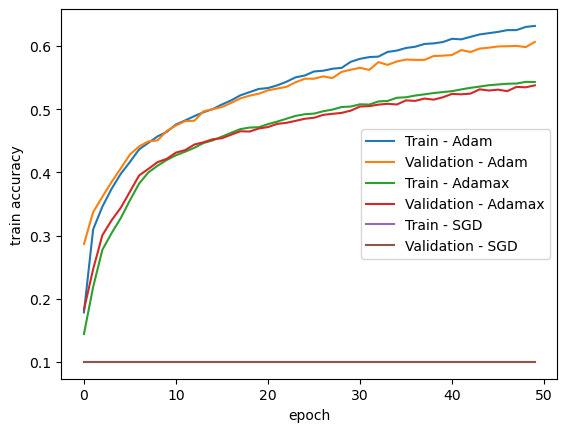

In [54]:
sns.lineplot(x='epoch', y ='train accuracy', data = model1Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1Results, label = 'Validation - Adam')
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultsAdaMax, label = 'Train - Adamax')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultsAdaMax, label = 'Validation - Adamax')
sns.lineplot(x='epoch', y ='train accuracy', data = model1ResultSGD, label = 'Train - SGD')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model1ResultSGD, label = 'Validation - SGD')

In [29]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = Model1()
model.to(device)
with torch.no_grad():
    correct = 0
    for x_test, y_test in testloader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        y_val = model(x_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
print(f'Test accuracy: {correct.item()}/{len( testset)} = {correct.item()*100/(len(testset)):7.3f}%')

Test accuracy: 1000/10000 =  10.000%


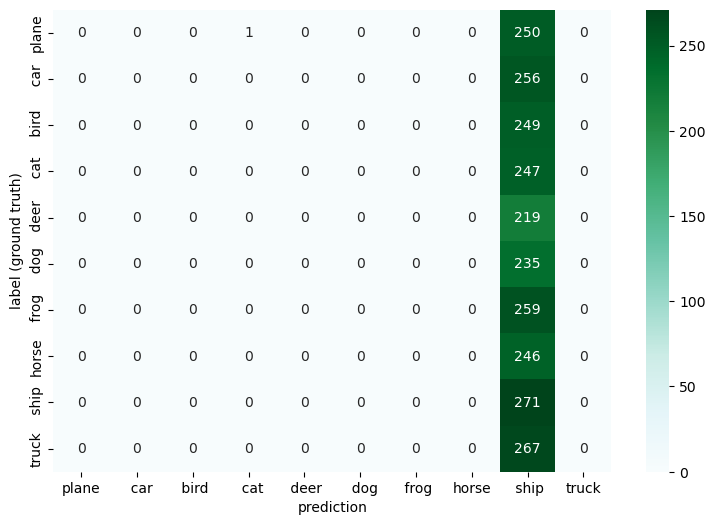

In [30]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1).detach().cpu().numpy(), predicted.view(-1).detach().cpu().numpy())
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show()

In [63]:
lossfunc = nn.CrossEntropyLoss()
model2 = Model2
model2Results = trainNetwork(model2, lossfunc, trainloader = trainloader, valloader = valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

In [61]:
lossfunc = nn.CrossEntropyLoss()
model2Adamax = Model2
model2ResultsAdamax = trainNetworkAdamax(model2Adamax, lossfunc, trainloader = trainloader, valloader = valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

<Axes: xlabel='epoch', ylabel='train accuracy'>

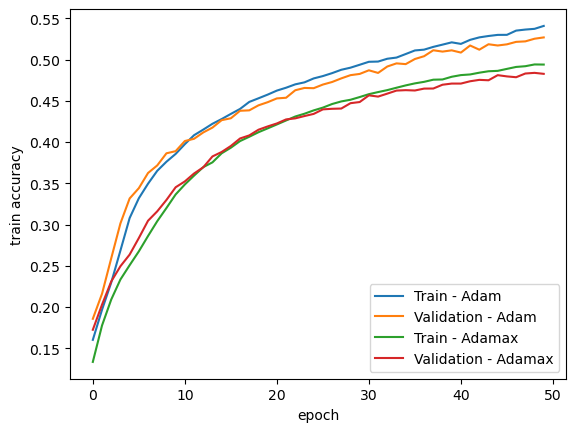

In [64]:
sns.lineplot(x='epoch', y ='train accuracy', data = model2Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model2Results, label = 'Validation - Adam')
sns.lineplot(x='epoch', y ='train accuracy', data = model2ResultsAdamax, label = 'Train - Adamax')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model2ResultsAdamax, label = 'Validation - Adamax')

In [5]:
lossfunc = nn.CrossEntropyLoss()
model2tanh = Model2Tanh
model2Results = trainNetwork(model2tanh, lossfunc, trainloader = trainloader, valloader = valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

<Axes: xlabel='epoch', ylabel='train accuracy'>

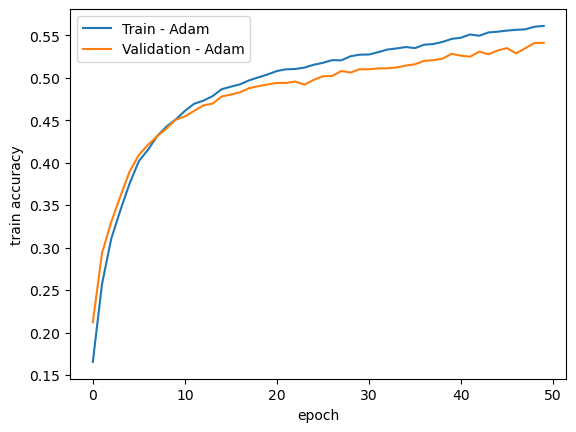

In [6]:
sns.lineplot(x='epoch', y ='train accuracy', data = model2Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model2Results, label = 'Validation - Adam')

In [5]:
lossfunc = nn.CrossEntropyLoss()
model3 = Model3
model3Results = trainNetwork(model3, lossfunc, trainloader = trainloader, valloader = valloader, scorefuncs={'accuracy': accuracy_score}, epochs=50)

OutOfMemoryError: CUDA out of memory. Tried to allocate 1.14 GiB (GPU 0; 15.99 GiB total capacity; 14.11 GiB already allocated; 0 bytes free; 14.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
sns.lineplot(x='epoch', y ='train accuracy', data = model3Results, label = 'Train - Adam')
sns.lineplot(x ='epoch',y = 'val accuracy', data = model3Results, label = 'Validation - Adam')